### This script experiments with converting NASA HMA [MAR](https://nsidc.org/data/HMA_MAR3_5/versions/1) data to ZARR format for more convenient aggregation and eventual validation against GRACE data

Zheng Liu, Anthony Arendt APL UW

In [1]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data

import os
import sys
import importlib
from glob import glob
from datetime import datetime, timedelta
import h5py
from dask import compute
import dask
from distributed import Client
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import scipy.optimize
from PyAstronomy import pyasl
from scipy import signal
from shapely.geometry import (Polygon, Point, box)
import boto3
import s3fs

import pyepsg

from matplotlib import pyplot as plt

import himatpy, himatpy.GRACE_MASCON.pygrace, himatpy.MAR.utils
importlib.reload(himatpy)
importlib.reload(himatpy.GRACE_MASCON.pygrace)
importlib.reload(himatpy.MAR.utils)
from himatpy.GRACE_MASCON.pygrace import __aggregate_mascon
from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, trend_analysis, get_cmwe_trend_analysis, select_mascons, aggregate_mascons)
from himatpy.MAR.utils import get_xr_dataset

from himatpy.LIS import utils as LISutils
from himatpy.MAR import utils as MARutils
from himatpy.tools import animation_tools

import warnings
warnings.filterwarnings('ignore')

In [2]:
MARutils.download_MAR(short_name = 'HMA_MAR3_5',
                      version = '1',
                      time_start = '2000-01-01T00:00:00Z',
                      time_end = '2000-03-31T23:59:59Z',
                      polygon = '',
                      filename_filter = '*'
                     )

Querying for data:
	https://cmr.earthdata.nasa.gov/search/granules.json?provider=NSIDC_ECS&sort_key[]=start_date&sort_key[]=producer_granule_id&scroll=true&page_size=2000&short_name=HMA_MAR3_5&version=001&version=01&version=1&temporal[]=2000-01-01T00:00:00Z,2000-03-31T23:59:59Z&producer_granule_id[]=*&options[producer_granule_id][pattern]=true

Found 1 matches.


Earthdata username:  arendta
password:  ····················


Incorrect username or password


Earthdata username:  arendta
password:  
password:  ··················


1/2: Data/MAR/HMA_MAR3_5_ICE.2000.01-12.h22.nc
2/2: Data/MAR/HMA_MAR3_5_ICE.2000.01-12.h22.nc.xml


### Read the data from local pangeo directory

See [this](https://github.com/pydata/xarray/issues/2624) note on chunk sizes

In [3]:
agg_fns = sorted(glob('Data/MAR/*.nc'))
ds = xr.open_mfdataset(agg_fns,autoclose=True,concat_dim='TIME',chunks={'TIME': 1})

### Take a quick look at some data

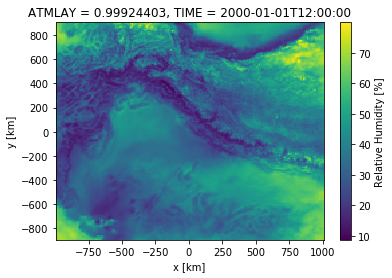

In [4]:
ds.RH.isel(TIME=0,ATMLAY=1).plot()

### Establish connection to S3

For now let's use Anthony's AWS account. This requires adding an additional set of access keys to the ```~/.aws/credentials``` file

In [5]:
SNAME    = 'test_MAR'
S3_root  = 'himat-data'
ZAR_path = os.path.join( S3_root , SNAME )
zpath    = os.path.join(ZAR_path,'MAR.zarr')

In [ ]:
session = boto3.Session(profile_name='anthony')
fs = s3fs.S3FileSystem(session=session)
store = s3fs.S3Map(root=zpath,s3=fs, check=False)

#### This is for converting to ZARR and pushing to S3:

In [ ]:
ds.to_zarr(store=store) 

#### This is for reading from ZARR:

In [ ]:
ds2 = xr.open_zarr(store)

Let's check the same plot again:

In [ ]:
ds2.RH.isel(TIME=0,ATMLAY=0).plot()